# Barcode Detection

This Notebook implements a full hand-drawn barcode detection pipeline (without error detection/correction).

In [2]:
IMAGE_PATH = "./test_images/559796_642999_452150_416041_265896_159225.jpg"

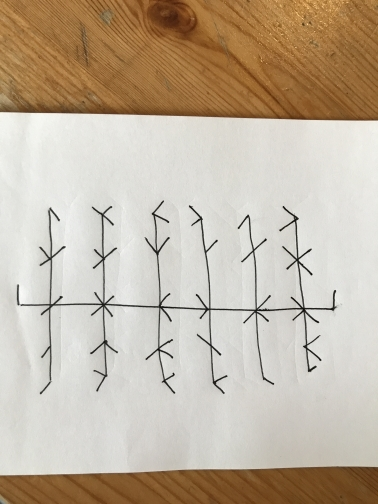

In [3]:
from PIL import Image 
  
#show the input image
im = Image.open(IMAGE_PATH)  
display(im)

## Import the Barcode Detection Model

In [4]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

#tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

In [6]:
MODEL_NAME = "faster_rcnn_resnet50_v1_640x640_coco17_tpu-8"
PATH_TO_SAVED_MODEL = "./exported-models/{}/saved_model".format(MODEL_NAME)

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 18.543283224105835 seconds


## ShowDetected Parts


In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [8]:
PATH_TO_LABELS = "./exported-models/{}/annotations/label_map.pbtxt".format(MODEL_NAME)
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Running inference for ./test_images/559796_642999_452150_416041_265896_159225.jpg... 

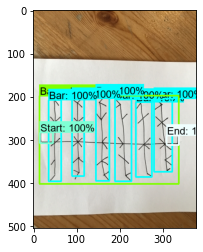

Done


In [9]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """    
    return np.array(Image.open(path))



print('Running inference for {}... '.format(IMAGE_PATH), end='')

image_np = load_image_into_numpy_array(IMAGE_PATH)

input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      line_thickness=4)

plt.imshow(image_np_with_detections)
plt.show()
print('Done')

## Import the Bar Categorization Model

In [10]:
print('Loading categorization model...', end='')
start_time = time.time()

cat_model = tf.keras.models.load_model('./exported-models/bar_cat_EfficientNetB2_9718')

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading categorization model...WARNING:tensorflow:Importing a function (__inference_block2c_activation_layer_call_and_return_conditional_losses_72147) with ops with custom gradients. Will likely fail if a gradient is requested.
Done! Took 47.437089681625366 seconds


## Get Bars

In [11]:
def crop(image, coords):
    cropped_image = image.crop(coords)
    cropped_image.show()

In [12]:
from math import atan2, degrees

In [13]:
def get_ordered_bars(image, detection_scores, detection_classes, detection_boxes, threshold):
    idx = 0
    while detection_scores[idx] > threshold:
        idx += 1
        
    if idx < 2:
        return
        
    classes = detection_classes[:idx]
    boxes = detection_boxes[:idx] # box coordinates are (ymin, xmin, ymax, xmax)
    
    bar_boxes = [b for i, b in enumerate(boxes) if classes[i] == 2]
    if len(bar_boxes) < 1:
        return
    
    try:
        start_idx = classes.tolist().index(3)   
        end_idx = classes.tolist().index(4) # make sure it also has an end
        # exact center points not needed for sorting or angle => optimized by not dividing the sum
        start_center = (boxes[start_idx][3] + boxes[start_idx][1], boxes[start_idx][2] + boxes[start_idx][0])  
        end_center = (boxes[end_idx][3] + boxes[end_idx][1], boxes[end_idx][2] + boxes[end_idx][0])        
        angle = degrees(atan2(end_center[1] - start_center[1], end_center[0] - start_center[0]))
        
        bars = [(b_box[3] + b_box[1], b_box[2] + b_box[0], b_box) for b_box in bar_boxes]
        
        # exact distance no needed => optimized by not using sqrt when sorting
        bars.sort(key = lambda p: (p[0] - start_center[0])**2 + (p[1] - start_center[1])**2) 
        
        bar_images = []
        for bar in bars:
            cropped = image.crop((bar[2][1] * image.size[0],
                                  bar[2][0] * image.size[1],
                                  bar[2][3] * image.size[0],
                                  bar[2][2] * image.size[1]))
            rotated = cropped.rotate(angle, Image.NEAREST, expand = True) 
            
            bar_images.append(rotated)
            
        return bar_images
            
    except ValueError:
        return

In [14]:
def get_bars(image_path):    
    image_np = load_image_into_numpy_array(image_path)

    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    ordered_bars = get_ordered_bars(Image.open(image_path), 
                                    detections['detection_scores'], 
                                    detections['detection_classes'], 
                                    detections['detection_boxes'],
                                    0.4)
    
    if ordered_bars is None:
        return
    
    return ordered_bars

In [15]:
bars = get_bars(IMAGE_PATH)

--------------------------------------------------
Bar 0:


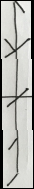

--------------------------------------------------
Bar 1:


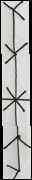

--------------------------------------------------
Bar 2:


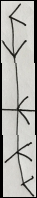

--------------------------------------------------
Bar 3:


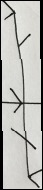

--------------------------------------------------
Bar 4:


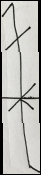

--------------------------------------------------
Bar 5:


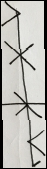

In [16]:
for idx, bar in enumerate(bars):
    print("-"*50)
    print("Bar " + str(idx) + ":")
    display(bar)

## Decode the bars

In [21]:
import keras
from keras.preprocessing import image

pred_y = []
for bar in bars:
    resized_bar = image.img_to_array(bar.resize((100, 450), Image.ANTIALIAS))
    bar_as_array = image.img_to_array(resized_bar)
    pred = cat_model.predict(bar_as_array.reshape((1, 450, 100, 3)))

    print(pred)
    #decode 
    index = 0
    decoded = 0
    for bit in (pred > 0.5).astype(int)[0]:
        decoded += bit << index
        index += 1

    print("DECODED:", decoded)
    pred_y.append(decoded)

[[8.43263697e-05 4.48981211e-07 9.99949098e-01 2.90837843e-09
  1.00000000e+00 1.00000000e+00 6.19676443e-09 9.99937296e-01
  7.89980414e-10 9.99616265e-01 7.18107403e-05 1.00000000e+00
  2.05733586e-09 1.66165864e-05 3.77325819e-07 9.99999642e-01
  5.51690568e-11 2.42632332e-08 1.43272585e-08 9.99798477e-01]]
DECODED: 559796
[[1.0000000e+00 1.0000000e+00 9.9999821e-01 1.4392881e-12 9.9999988e-01
  1.0000000e+00 5.2620366e-04 9.9997818e-01 9.9999118e-01 9.9999309e-01
  9.9999988e-01 1.0000000e+00 3.5773340e-12 7.3807964e-09 9.9999821e-01
  9.9999988e-01 9.9823642e-01 3.7925027e-03 2.3899266e-13 1.2461298e-01]]
DECODED: 118711
[[5.5363871e-05 9.9977475e-01 1.0000000e+00 1.0607204e-06 9.9999857e-01
  1.0000000e+00 3.4690249e-05 2.7266029e-07 4.6939299e-06 9.9999988e-01
  1.0000000e+00 1.1476281e-07 2.2285067e-09 1.0000000e+00 9.9956995e-01
  1.0000000e+00 3.2371654e-11 1.0000000e+00 9.9999523e-01 3.2639466e-06]]
DECODED: 452150
[[9.9999678e-01 6.2690531e-10 6.6257030e-12 1.0000000e+00 1.

In [18]:
pred_y

[559796, 118711, 452150, 416041, 265896, 151033]

In [51]:
IMAGE_PATH

'./test_images/559796_642999_452150_416041_265896_159225.jpg'

In [19]:
print("""
Bar1 : {:020b} ({:d}), 
Pred : {:020b} ({:d}), 
Error: {:020b}

Bar2: {:020b} ({:d}), 
Predicted: {:020b} ({:d}),
Error: {:020b}

Bar3: {:020b} ({:d}),
Predicted: {:020b} ({:d}),
Error: {:020b}

Bar4: {:020b} ({:d}), 
Predicted: {:020b} ({:d}), 
Error: {:020b}

Bar5: {:020b} ({:d}), 
Predicted: {:020b} ({:d}), 
Error: {:020b}

Bar6: {:020b} ({:d}),
Predicted: {:020b} ({:d}),
Error: {:020b}
""".format(559796, 559796, pred_y[0], pred_y[0], 559796 ^ pred_y[0], 
           642999, 642999, pred_y[1], pred_y[1], 642999 ^ pred_y[1],
           452150, 452150, pred_y[2], pred_y[2], 452150 ^ pred_y[2],
           416041, 416041, pred_y[3], pred_y[3], 416041 ^ pred_y[3],
           265896, 265896, pred_y[4], pred_y[4], 265896 ^ pred_y[4],
           159225, 159225, pred_y[5], pred_y[5], 159225 ^ pred_y[5]))


Bar1 : 10001000101010110100 (559796), 
Pred : 10001000101010110100 (559796), 
Error: 00000000000000000000

Bar2: 10011100111110110111 (642999), 
Predicted: 00011100111110110111 (118711),
Error: 10000000000000000000

Bar3: 01101110011000110110 (452150),
Predicted: 01101110011000110110 (452150),
Error: 00000000000000000000

Bar4: 01100101100100101001 (416041), 
Predicted: 01100101100100101001 (416041), 
Error: 00000000000000000000

Bar5: 01000000111010101000 (265896), 
Predicted: 01000000111010101000 (265896), 
Error: 00000000000000000000

Bar6: 00100110110111111001 (159225),
Predicted: 00100100110111111001 (151033),
Error: 00000010000000000000

